In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.models import load_model
from keras import layers
import os
import tensorflow as tf
import datetime
from collections import deque
from keras.callbacks import ModelCheckpoint
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_absolute_error


In [107]:

df_all = pd.read_csv('NVDA.csv')
df_all.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
df_all['Date'] = pd.to_datetime(df_all['Date'])
df_all = df_all[['Date', 'Close']]

train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


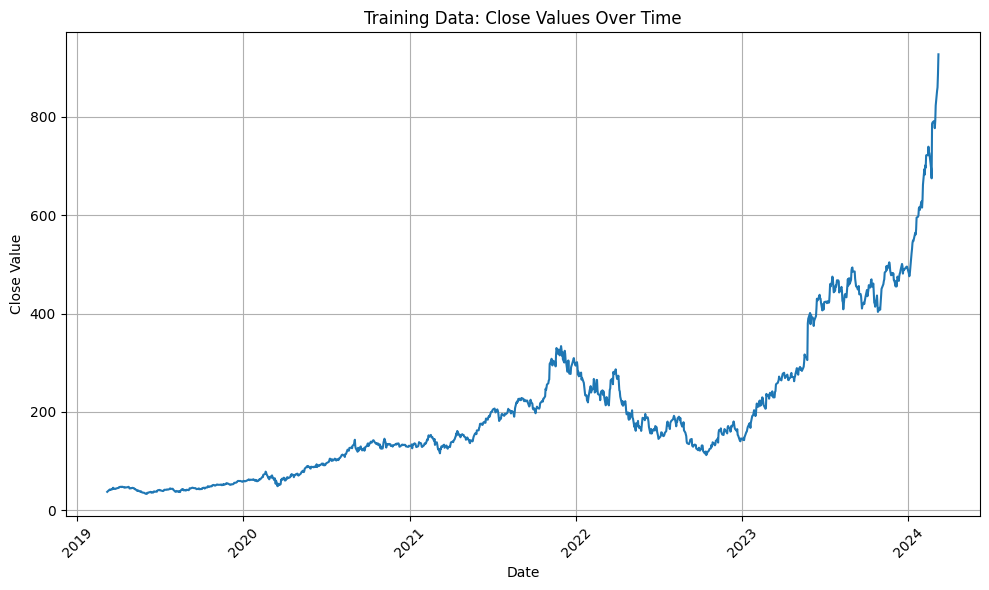

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df_all['Date'], df_all['Close'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# datapreprocessing for lstm

In [7]:

def generate_windowed_dataset(dataframe, start_date_str, end_date_str, col_name, window_size):
    start_date = pd.to_datetime(start_date_str)
    end_date = pd.to_datetime(end_date_str)

    target_date = start_date
    dates = []
    X, y = [], []

    while True:
        window_data = dataframe.loc[:target_date].tail(window_size + 1)

        if len(window_data) != window_size + 1:
            print(f'Error: Window of size {window_size} is too large for date {target_date}')
            return

        values = window_data[col_name].to_numpy()
        X.append(values[:-1])
        y.append(values[-1])
        dates.append(target_date)

        next_date = target_date + pd.tseries.offsets.BDay(1)  # Move to the next business day

        if next_date > end_date:
            break

        # Move to the next trading day
        while next_date not in dataframe.index:
            next_date += pd.tseries.offsets.BDay(1)

        target_date = next_date

    ret_df = pd.DataFrame({'Target Date': dates})
    for i in range(window_size):
        ret_df[f'Target-{window_size-i}'] = np.array(X)[:, i]
    ret_df['Target'] = y  # Last target value

    return ret_df

# windowed_df = generate_windowed_dataset(train_df,
#                                         '2021-08-25',
#                                         '2022-08-31',
#                                         'Close',
#                                         3)
# print(windowed_df)


In [8]:
def prepare_dataset_for_lstm(windowed_dataframe):
    dates = windowed_dataframe['Target Date'].to_numpy()
    X = windowed_dataframe.iloc[:, 1:-1].to_numpy().reshape(len(windowed_dataframe), -1, 1)
    y = windowed_dataframe['Target'].to_numpy()
    return dates, X.astype(np.float32), y.astype(np.float32)


# w = prepare_dataset_for_lstm(windowed_df)[1]
# w.shape

# LSTM Baseline

## preprocessing

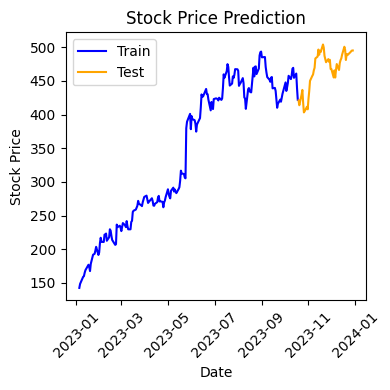

In [197]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [253]:
model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

model.save(os.path.join(save_dir, 'baseline.keras'))

SyntaxError: invalid syntax (1236887578.py, line 3)

## plotting

7/7 [==============================] - 0s 1ms/step


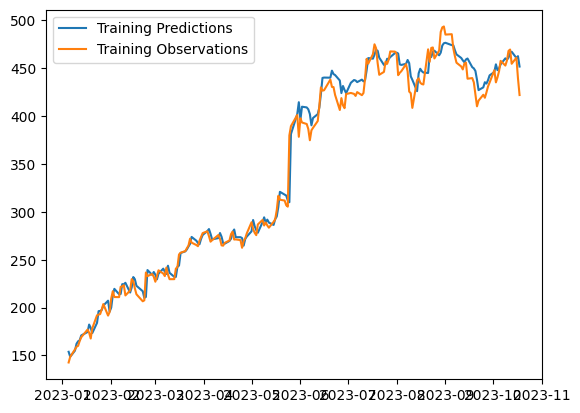

In [199]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 2ms/step


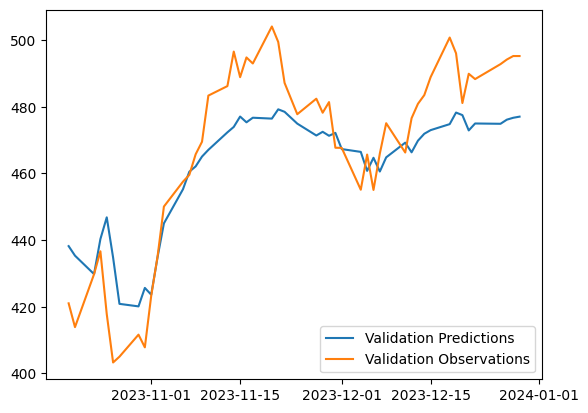

In [200]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

## evaluating on test set

1/1 [==============================] - 0s 401ms/step - loss: 3045.8218 - mean_absolute_error: 52.7628
Test Loss: 3045.82177734375
Test Mean Absolute Error: 52.762847900390625
[481.679993, 475.690002, 479.980011]
deque([481.679993, 475.690002, 479.980011], maxlen=3)
[481.679993, 475.690002, 479.980011]
1/1 [==============================] - 0s 217ms/step


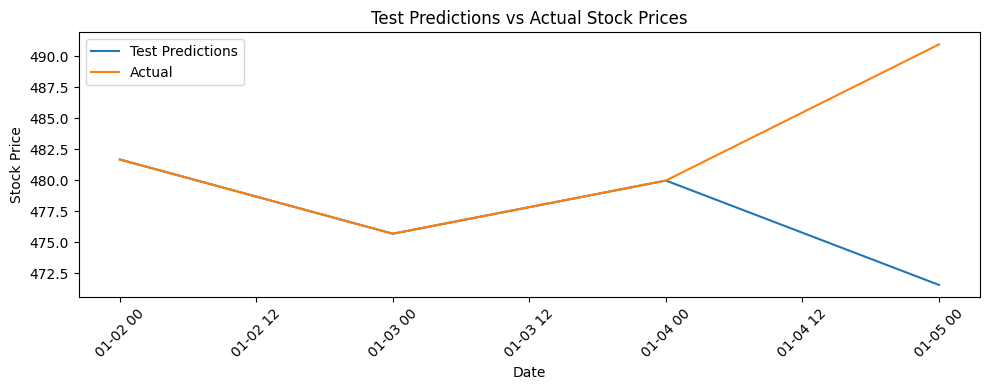

In [108]:
model = load_model('trained_models/baseline.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)


loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 4
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(values)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df_all)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Z-score scaling

In [173]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

test_df = pd.read_csv('NVDA_test.csv')
test_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
test_df['Date'] = pd.to_datetime(test_df['Date'])
test_df = test_df[['Date', 'Close']]
test_df.index = test_df.pop('Date')


train_mean = train_df['Close'].mean()
train_std = train_df['Close'].std()

test_mean = test_df['Close'].mean()
test_std = test_df['Close'].std()

# Apply z-score normalization
train_df['Close'] = (train_df['Close'] - train_mean) / train_std
test_df['Close'] = (test_df['Close'] - test_mean) / test_std

## preprocessing

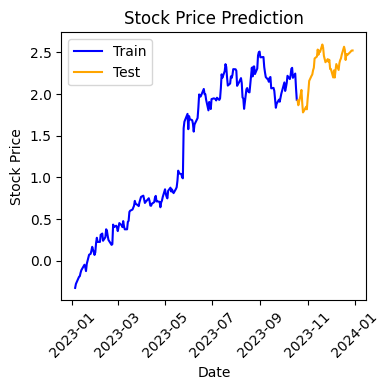

In [144]:
windowed_df = generate_windowed_dataset(train_df, '2023-01-05', '2023-12-29', 'Close', 3)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

## training

In [170]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(3, len(['Close']))))
model.add(Dropout(0.3))
model.add(LSTM(120, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(20))
model.add(Dense(1))

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'zscore_.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=1)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10000,
                    callbacks=[checkpoint], verbose=0)


Epoch 1: val_loss improved from inf to 2.55850, saving model to trained_models\zscore_.keras

Epoch 2: val_loss improved from 2.55850 to 0.05596, saving model to trained_models\zscore_.keras

Epoch 3: val_loss did not improve from 0.05596

Epoch 4: val_loss did not improve from 0.05596

Epoch 5: val_loss did not improve from 0.05596

Epoch 6: val_loss improved from 0.05596 to 0.01119, saving model to trained_models\zscore_.keras

Epoch 7: val_loss did not improve from 0.01119

Epoch 8: val_loss did not improve from 0.01119

Epoch 9: val_loss did not improve from 0.01119

Epoch 10: val_loss did not improve from 0.01119

Epoch 11: val_loss improved from 0.01119 to 0.01102, saving model to trained_models\zscore_.keras

Epoch 12: val_loss did not improve from 0.01102

Epoch 13: val_loss did not improve from 0.01102

Epoch 14: val_loss did not improve from 0.01102

Epoch 15: val_loss did not improve from 0.01102

Epoch 16: val_loss did not improve from 0.01102

Epoch 17: val_loss did not i

## plotting

2/2 [==============================] - 0s 3ms/step


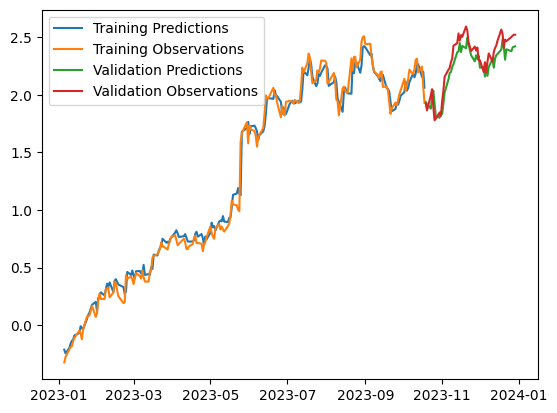

In [174]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions, label='Training Predictions')
plt.plot(dates_train, y_train, label='Training Observations')
plt.legend()

val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions, label='Validation Predictions')
plt.plot(dates_val, y_val, label='Validation Observations')
plt.legend()

plt.show()


## evaluating on test set

1/1 [==============================] - 1s 704ms/step - loss: 0.0405 - mean_absolute_error: 0.1820
Test Loss: 0.04051936790347099
Test Mean Absolute Error: 0.1820482462644577
1/1 [==============================] - 0s 14ms/step


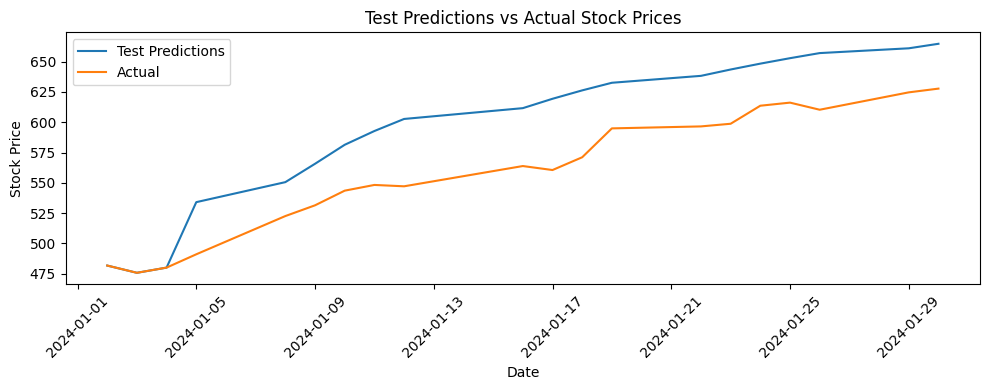

In [180]:
model = load_model('trained_models/zscore.keras')
windowed_test_df = generate_windowed_dataset(test_df, '2024-01-05', '2024-01-15', 'Close', 3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 20
s = 0

values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()
measures = deque(values, maxlen=3)
measures_list = list(measures)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)

values = [(val * test_std) + test_mean for val in values]
actual_values = test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist()
actual_values = [(val * test_std) + test_mean for val in actual_values]

# Plotting
plt.figure(figsize=(10, 4))
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, actual_values, label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Returns 

In [172]:
train_df = pd.read_csv('NVDA_train.csv')
train_df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'], inplace=True)
train_df['Date'] = pd.to_datetime(train_df['Date'])
train_df = train_df[['Date', 'Close']]
train_df.index = train_df.pop('Date')

df_ret_train = train_df
df_ret_train['Return'] = df_ret_train['Close'].pct_change()
df_ret_train.drop(columns=['Close'], inplace=True)
df_ret_train.dropna(inplace=True)


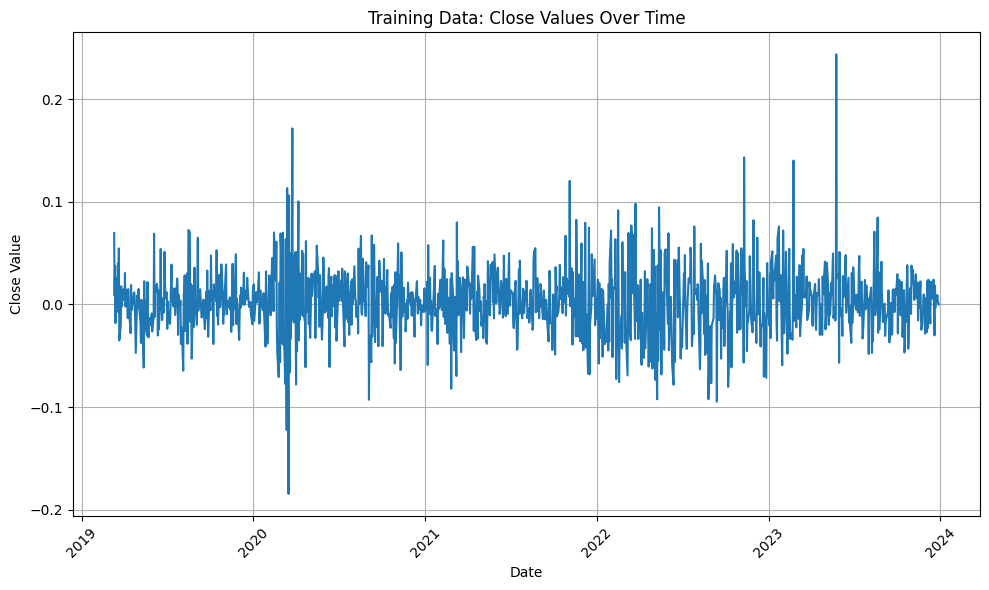

In [211]:
plt.figure(figsize=(10, 6))
plt.plot(df_ret_train.index, df_ret_train['Return'], marker='', linestyle='-')
plt.title('Training Data: Close Values Over Time')
plt.xlabel('Date')
plt.ylabel('Close Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


    Target Date  Target-10  Target-9  Target-8  Target-7  Target-6  Target-5  \
0    2023-01-05  -0.010397  0.025863 -0.070420 -0.008671 -0.071353 -0.006019   
1    2023-01-06   0.025863 -0.070420 -0.008671 -0.071353 -0.006019  0.040396   
2    2023-01-09  -0.070420 -0.008671 -0.071353 -0.006019  0.040396  0.000753   
3    2023-01-10  -0.008671 -0.071353 -0.006019  0.040396  0.000753 -0.020460   
4    2023-01-11  -0.071353 -0.006019  0.040396  0.000753 -0.020460  0.030318   
..          ...        ...       ...       ...       ...       ...       ...   
243  2023-12-22   0.019530 -0.018503  0.022090  0.009044  0.005448  0.011169   
244  2023-12-26  -0.018503  0.022090  0.009044  0.005448  0.011169  0.024279   
245  2023-12-27   0.022090  0.009044  0.005448  0.011169  0.024279 -0.009445   
246  2023-12-28   0.009044  0.005448  0.011169  0.024279 -0.009445 -0.030098   
247  2023-12-29   0.005448  0.011169  0.024279 -0.009445 -0.030098  0.018270   

     Target-4  Target-3  Target-2  Targ

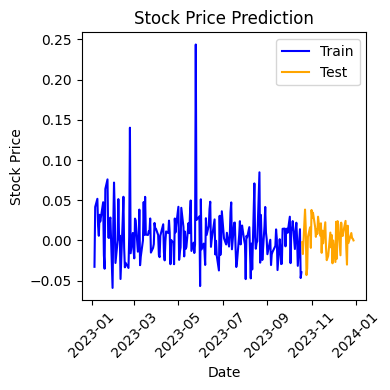

In [212]:
windowed_df = generate_windowed_dataset(df_ret_train, '2023-01-05', '2023-12-29', 'Return', 10)
dates, X, y = prepare_dataset_for_lstm(windowed_df)

print(windowed_df)

split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_val, y_val = X[split:], y[split:]
dates_train, dates_val = dates[:split], dates[split:]

# plot
plt.figure(figsize=(4, 4))
plt.plot(dates_train, y_train, label='Train', color='blue')
plt.plot(dates_val, y_val, label='Test', color='orange')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Stock Price Prediction')

plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# Training

In [205]:
model = Sequential([
    layers.Input((10, 1)),
    layers.LSTM(64),
    layers.Dense(32, activation='relu'),
    layers.Dense(32, activation='relu'),
    layers.Dense(1)
])

model.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])


save_dir = 'trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Define a ModelCheckpoint callback
checkpoint_path = os.path.join(save_dir, 'return.keras')
checkpoint = ModelCheckpoint(checkpoint_path,
                             monitor='val_loss',  # Choose the metric to monitor
                             save_best_only=True,  # Save only the best model
                             mode='min',  # 'min' for validation loss, 'max' for accuracy, 'auto' for automatic
                             verbose=0)

# Train the model with the callback
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=1000,
                    callbacks=[checkpoint], verbose=0)


7/7 [==============================] - 0s 1ms/step


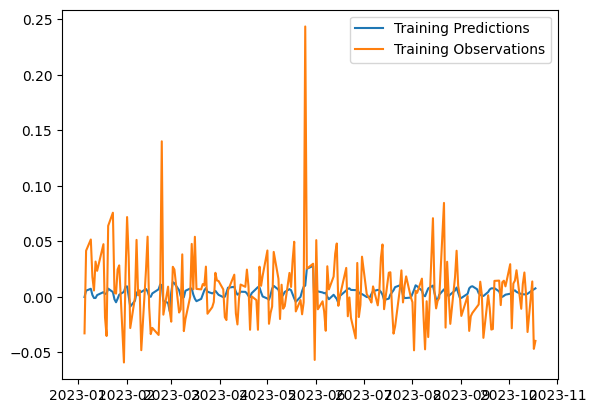

In [206]:
# Load the best model


return_model = load_model('trained_models/return.keras')
train_predictions = return_model.predict(X_train).flatten()


plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

2/2 [==============================] - 0s 3ms/step


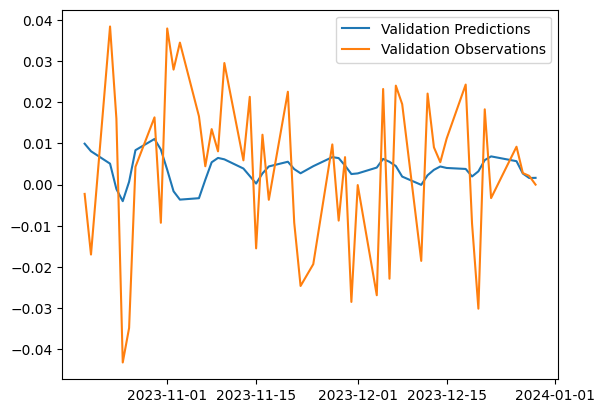

In [207]:
val_predictions = return_model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

In [208]:
from keras.models import load_model
from keras.optimizers import Adam


model = load_model('trained_models/return.keras')


windowed_test_df = generate_windowed_dataset(test_df, '2024-01-06', '2024-01-15', 'Close',3)
dates_test, X_test, y_test = prepare_dataset_for_lstm(windowed_test_df)

# print(dates_test)

loss, mae = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')
print(f'Test Mean Absolute Error: {mae}')

n = 4
s = 1


values = test_df[['Close']].iloc[s:s+3].to_numpy().flatten().tolist()
dates = test_df.iloc[s:s+n].index.to_list()

print(dates)


measures = deque(values, maxlen=3)
measures_list = list(measures)

print(measures)
print(measures_list)

for date in range(n-3):
    x = np.array(measures, dtype=float).reshape((1,3,1))
    pred_measure = 1+model.predict(x).flatten()[0]
    measures.append(pred_measure)
    values.append(pred_measure)


plt.figure(figsize=(10, 4))
# plt.plot(df)
plt.plot(dates, values, label='Test Predictions')
plt.plot(dates, test_df[['Close']].iloc[s:s+n].to_numpy().flatten().tolist(), label='Actual')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('Test Predictions vs Actual Stock Prices')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

ValueError: in user code:

    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2066, in test_function  *
        return step_function(self, iterator)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2049, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 2037, in run_step  **
        outputs = model.test_step(data)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py", line 1917, in test_step
        y_pred = self(x, training=False)
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\gusta\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_13" is incompatible with the layer: expected shape=(None, 10, 1), found shape=(None, 3, 1)


# News

In [220]:
import pandas as pd

file_path = 'news_retrieval/labelled_newscatcher_dataset.csv'

# Load the data and select specific columns
df = pd.read_csv(file_path, sep=';')

# Convert 'published_date' to datetime format
df['published_date'] = pd.to_datetime(df['published_date'])

# Select specific columns
df = df[['published_date', 'title']]

# Filter rows containing the word 'AI' in the 'title' column
df['contains_AI'] = df['title'].str.contains('AI', case=True)

# Create a new DataFrame with counts of AI articles published each day
daily_AI_counts = df.groupby(df['published_date'].dt.date)['contains_AI'].sum().reset_index()
daily_AI_counts.columns = ['published_date', 'AI_articles_count']

# Sort the new DataFrame by 'published_date'
daily_AI_counts = daily_AI_counts.sort_values(by='published_date')

print(daily_AI_counts)


    published_date  AI_articles_count
0       2012-09-16                  0
1       2015-10-23                  0
2       2016-09-23                  0
3       2016-12-08                  0
4       2016-12-22                  0
..             ...                ...
258     2020-08-14                 16
259     2020-08-15                 17
260     2020-08-16                  6
261     2020-08-17                 32
262     2020-08-18                  3

[263 rows x 2 columns]


# Comments

In [ ]:
# Very bad extrapolation (learn data outside its range), for it to better extrapolate we can train it on a smaller interval closer the dates we actually want to predict
# In most models its good to minmax scale, but not in the case of stock market predictions because there is no maximum value prices are always increasing
